<a href="https://colab.research.google.com/github/schmelto/machine-learning/blob/main/Deeplearning/Complex_layer_structure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Complex layer structure


## Imports

In [ ]:
%tensorflow_version 2.x # Command for Google Colab for Tensorflow 2

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x # Command for Google Colab for Tensorflow 2`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


In [ ]:
# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.test.is_gpu_available():
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")


### All required Keras classes are imported here, as well as other packages that are required for the execution

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Activation, Input, \
  Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# jupyters notebook Befehl zum direkten Anzeigen von Matplotlib Diagrammen
%matplotlib inline

## Helpers


In [ ]:
import typing
from typing import TYPE_CHECKING

import matplotlib.pyplot as plt
import numpy as np

if TYPE_CHECKING:  # pragma: no cover
    import keras.models
    import tensorflow as tf
    from tensorflow.keras.callbacks import History
    from tensorflow.python.data.ops.dataset_ops import DatasetV1Adapter

def plot_images(images: "DatasetV1Adapter", class_names: typing.List[str]) -> None:
    plt.figure(figsize=(12, 10))
    index = 0
    for image, label in images:
        index += 1
        plt.subplot(3, 3, index)
        plt.imshow(image)
        plt.title("Class: {}".format(class_names[label]))
        plt.axis("off")

def plot_history(title: str, history: "History", ylim: float = 0.6) -> None:
    y = history.history["accuracy"]
    y_test = history.history["val_accuracy"]
    plot_learning_curve(title, np.arange(1, 1 + len(y)), y, y_test, ylim)

## Information about the record

Via `tfds.load` you can display information about the dataset itself as well as information about it

In [ ]:
# Download the dataset
data, info = tfds.load(
    "imagenette/320px",
    as_supervised=True,
    with_info=True
)

# Size of the training data set
dataset_size = info.splits['train'].num_examples

# Größe des Validierungsdatensatzes
dataset_size_val = info.splits['validation'].num_examples

print('dataset size: ', dataset_size)
print('dataset size val: ', dataset_size_val)

# Information about the class names and number of classes
class_names = info.features['label'].names
print('class names: ', class_names)
n_classes = info.features['label'].num_classes
print('number of classes: ', n_classes)

dataset size:  12894
dataset size val:  500
class names:  ['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079', 'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257']
number of classes:  10


The data record can be viewed using the helper function. This is useful to get an overview of the existing data. You can also use it to identify problems, for example if the images were not loaded correctly.

If the data has already been preprocessed (see below) `train_data.unbatch().take(9)` must be called.

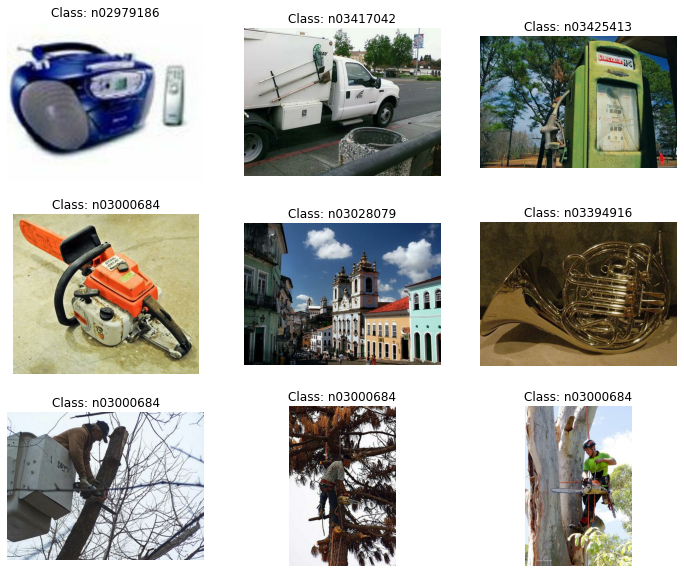

In [ ]:
# Display of 9 pictures from the training data set
plot_images(data['train'].take(9), class_names)

## Preprocessing the data

In order to be able to work with the image data, they must have a uniform size. For this we provide you with the function `preprocess`, which converts all images into the specified size

In [ ]:
def preprocess(image, label):
    resized_image = tf.image.resize(image/255, [300, 300])
    return resized_image, label

### Loading the data set

In [ ]:
train_data = tfds.load(
    'imagenette/320px',
    split=tfds.Split.TRAIN,
    as_supervised=True
)
test_data = tfds.load(
    'imagenette/320px',
    split=tfds.Split.VALIDATION,
    as_supervised=True
)

# Of course, data can also be loaded onto the training and validation via the `data` variable
# This can be done via data ['validation'] and data ['train'].
# In order to be able to use the code independently of the above, this has been listed again here.

## Prepare the data for faster processing
Application of the `preprocess` function to all data

`.batch` prepares the next batch with a specified size

`.prefetch` is already loading the next batch into memory

In [ ]:
# Definition of the batch size for data preparation
batch_size = 32 

# Mixing of the training data so that training is not carried out with sorted images

train_data = train_data.shuffle(1000) 

print('shape of the training data set before preprocessing: ', train_data)

train_data = train_data.map(preprocess) \
  .batch(batch_size).prefetch(1)          
test_data = test_data.map(preprocess) \
  .batch(batch_size).prefetch(1)

print('shape of the training data set after preprocessing: ', train_data)

shape of the training data set before preprocessing:  <ShuffleDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
shape of the training data set after preprocessing:  <PrefetchDataset shapes: ((None, 300, 300, 3), (None,)), types: (tf.float32, tf.int64)>


## First model that is trained with the new data set.

Here is some information about the model:
- After the input layer, the model consists of 6 convolutional layers, each with a max-pooling layer
- Before the layers begin to be classified, there is a flatten layer
- This is followed by 2 layers of dense layers with 500 and 250 neurons each
- Finally the output function follows with the `softmax` activation function


In the first convolutional layer a `kernel_size` of `(7,7)` is used to reduce the image dimension.

### Problem with this network

The same number of filters are used for the convolutional layer in each layer. This shouldn't be the case. Usually only a few filters are used at the beginning, which increase with the number of layers.

In [ ]:
# Parameters of the model
learning_rate=0.0001
momentum=0.9
dense_neurons=500
n_filters=32
first_kernel_size=(7,7)

activation='elu'

# Input size must be 300x300 pixels with 3 RGB colors
input_layer = Input(shape=(300, 300, 3))

# Convolutional Neural Network
# 6 Convolutional Layers, each with a Max Pooling Layer
model = Conv2D(
    filters=n_filters,
    kernel_size=(7,7),
    activation=activation
)(input_layer)
model = MaxPooling2D((2,2))(model)

model = Conv2D(
    filters = 32, 
    kernel_size=(3,3), 
    activation=activation
  )(model)
model = MaxPooling2D((2,2))(model)

model = Conv2D(
    filters = 32, 
    kernel_size=(3,3), 
    activation=activation
  )(model)
model = MaxPooling2D((2,2))(model)

model = Conv2D(
    filters = 32, 
    kernel_size=(3,3), 
    activation=activation
  )(model)
model = MaxPooling2D((2,2))(model)

model = Conv2D(
    filters = 32, 
    kernel_size=(3,3), 
    activation=activation
  )(model)
model = MaxPooling2D((2,2))(model)

model = Conv2D(filters = 32, 
  kernel_size=(3,3), 
  activation=activation, 
  padding='same'
)(model)
model = MaxPooling2D((2,2))(model)

# Fully-Connected-Classifier
model = Flatten()(model)
model = Dense(
    dense_neurons,
    activation=activation
)(model)

model = Dense(
    dense_neurons / 2,
    activation='tanh'
)(model)

# Output Layer
output = Dense(
    n_classes,
   activation="softmax"
)(model)

CNN_model = Model(input_layer, output)

# Compile the model
optimizer = keras.optimizers.SGD(
    lr=learning_rate,
    momentum=momentum
)
CNN_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=optimizer,
    metrics=["accuracy"]
)

In [ ]:
CNN_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 294, 294, 32)      4736      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 147, 147, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 145, 145, 32)      9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 72, 72, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 70, 70, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 35, 35, 32)        0   

In [ ]:
# Training the model
history = CNN_model.fit(
    train_data,
    epochs=12,
    validation_data=test_data
)

Epoch 1/12
403/403 [==============================] - 39s 80ms/step - loss: 2.2977 - accuracy: 0.1255 - val_loss: 2.2645 - val_accuracy: 0.2040
Epoch 2/12
403/403 [==============================] - 32s 79ms/step - loss: 2.2570 - accuracy: 0.2074 - val_loss: 2.1717 - val_accuracy: 0.2560
Epoch 3/12
403/403 [==============================] - 32s 78ms/step - loss: 2.1636 - accuracy: 0.2338 - val_loss: 2.0210 - val_accuracy: 0.2720
Epoch 4/12
403/403 [==============================] - 32s 78ms/step - loss: 2.0648 - accuracy: 0.2715 - val_loss: 1.9298 - val_accuracy: 0.3160
Epoch 5/12
403/403 [==============================] - 32s 78ms/step - loss: 1.9924 - accuracy: 0.3101 - val_loss: 1.8644 - val_accuracy: 0.3440
Epoch 6/12
403/403 [==============================] - 32s 78ms/step - loss: 1.9214 - accuracy: 0.3396 - val_loss: 1.8006 - val_accuracy: 0.3720
Epoch 7/12
403/403 [==============================] - 32s 78ms/step - loss: 1.8557 - accuracy: 0.3658 - val_loss: 1.7355 - val_accuracy:

### Visualization of the results of the first network

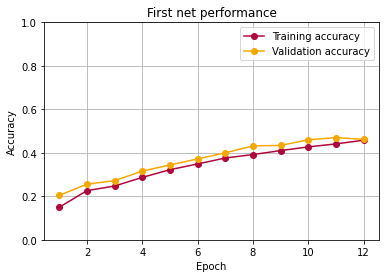

In [ ]:
plot_history('First net performance', history, 0)

## Better structure of the network

Here the filter size is set higher in the later layers. Furthermore, the number of dense neurons for the layers at the end of the network was doubled.

Otherwise the network is set up as above.

Better results can be achieved with this.

In [ ]:
# model
learning_rate=0.001
momentum=0.9
dense_neurons=1000
n_filters=512
first_kernel_size=(7,7)

activation='elu'

# Input size must be 300x300 pixels with 3 RGB colors
input_layer = Input(shape=(300, 300, 3))

# Convolutional Neural Network
# 6 Convolutional Layers, each with a Max Pooling Layer
model = Conv2D(
    filters=256,
    kernel_size=(7,7),
    activation=activation
)(input_layer)
model = MaxPooling2D((2,2))(model)

model = Conv2D(
    filters = 256, 
    kernel_size=(3,3), 
    activation=activation
)(model)
model = MaxPooling2D((2,2))(model)

model = Conv2D(
    filters = n_filters, 
    kernel_size=(3,3), 
    activation=activation
)(model)
model = MaxPooling2D((2,2))(model)

model = Conv2D(
    filters = n_filters, 
    kernel_size=(3,3), 
    activation=activation
)(model)
model = MaxPooling2D((2,2))(model)

model = Conv2D(
    filters = n_filters, 
    kernel_size=(3,3), 
    activation=activation
)(model)
model = MaxPooling2D((2,2))(model)

model = Conv2D(filters = n_filters, 
  kernel_size=(3,3), 
  activation=activation, 
  padding='same'
)(model)
model = MaxPooling2D((2,2))(model)

# Fully-Connected-Classifier
model = Flatten()(model)
model = Dense(
    dense_neurons,
    activation=activation
)(model)

model = Dense(
    dense_neurons / 2,
    activation='tanh'
)(model)

# Output Layer
output = Dense(n_classes, activation="softmax")(model)

CNN_model = Model(input_layer, output)

# Compile the model
optimizer = keras.optimizers.SGD(lr=learning_rate, momentum=momentum)
CNN_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=optimizer,
    metrics=["accuracy"]
)
CNN_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 294, 294, 256)     37888     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 147, 147, 256)     0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 145, 145, 256)     590080    
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 72, 72, 256)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 70, 70, 512)       1180160   
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 35, 35, 512)       0   

In [ ]:
# Training the 12 epoch model
history2 = CNN_model.fit(
    train_data,
    epochs=12,
    validation_data=test_data
)

Epoch 1/12
403/403 [==============================] - 161s 391ms/step - loss: 2.0941 - accuracy: 0.2483 - val_loss: 1.5645 - val_accuracy: 0.4880
Epoch 2/12
403/403 [==============================] - 155s 384ms/step - loss: 1.4789 - accuracy: 0.5070 - val_loss: 1.1872 - val_accuracy: 0.6000
Epoch 3/12
403/403 [==============================] - 155s 383ms/step - loss: 1.1990 - accuracy: 0.6034 - val_loss: 1.0714 - val_accuracy: 0.6700
Epoch 4/12
403/403 [==============================] - 155s 383ms/step - loss: 1.0236 - accuracy: 0.6618 - val_loss: 0.9500 - val_accuracy: 0.7000
Epoch 5/12
403/403 [==============================] - 155s 383ms/step - loss: 0.8815 - accuracy: 0.7125 - val_loss: 0.9303 - val_accuracy: 0.6860
Epoch 6/12
403/403 [==============================] - 155s 383ms/step - loss: 0.7299 - accuracy: 0.7620 - val_loss: 0.8707 - val_accuracy: 0.7220
Epoch 7/12
403/403 [==============================] - 155s 383ms/step - loss: 0.5973 - accuracy: 0.8050 - val_loss: 0.8736 -

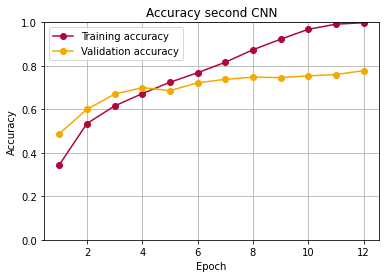

In [ ]:
plot_history('Accuracy second CNN', history2, 0)

## Tips on how to proceed

### Depth of the network

It is recommended to use two layers with a smaller kernel instead of one layer with a large kernel. This means that fewer parameters are used despite the expansion of the depth of the network.

In [ ]:
# Not correct:
model = Conv2D(
    filters=32,
    kernel_size=(7,7),
    activation=activation
)(input_layer)

# Better:
model = Conv2D(
    filters=32,
    kernel_size=(3,3),
    activation=activation
)(input_layer)
model = Conv2D(
    filters=32,
    kernel_size=(3,3),
    activation=activation
)(model)
# fewer parameters, fewer multiplications
# but deeper structure

### First layer of the network

A large kernel like (7,7) with strides of (2,2) can be used to reduce the image size

In [ ]:
# first layer of the network:
model = Conv2D(
    filters=32,
    kernel_size=(7,7),
    strides=(2, 2),
    activation=activation
)(input_layer)
# large kernel and large stride
# this reduces large images easily and well

## How can I add more convolutional layers?

### It is not always possible to reduce the image size

Since the image size can only be reduced to a limited extent, max pooling layers should no longer be used at the end.

Furthermore, `padding` must be set to` same` in the convolutional layers.

---

max_pooling2d_50 (MaxPooling (None, 7, 7, 320) 0

---

conv2d_51 (Conv2D) (None, 7, 7, 320) 921920

---

max_pooling2d_51 (MaxPooling (None, 3, 3, 320) 0





In [ ]:
model = Conv2D(
    filters=32,
    kernel_size=(3,3),
    activation=activation,
    padding='same'
)(input_layer)
# no more max pooling layer
model = Conv2D(
    filters=32,
    kernel_size=(3,3),
    activation=activation,
    padding='same'
)(model)